In [1]:
import matplotlib as mpl
import matplotlib.cm
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import numpy as np
import pandas as pd
#from math import *
from datetime import datetime
from matplotlib.transforms import offset_copy
from matplotlib.ticker import FormatStrFormatter
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import geopy.distance
from scipy.stats import norm


plt.rcParams["figure.figsize"] = (8,8)
plt.rcParams.update({'font.size': 16})

# uBlox GPS log file processing
Annie Polish, March 2021

---
## Reading in a file

Index(['iTOW', 'UTC', 'tAcc', 'Lon', 'Lat', 'Height', 'HMSL', 'hAcc', 'vAcc',
       'pDOP', 'numSV', 'velN', 'velE', 'velD', 'gspeed', 'headmot', 'sAcc',
       'headAcc', 'fixType', 'fixOK', 'UTCvalid', 'HPvalid', 'diffCorrected'],
      dtype='object')


(41.318006079, 41.324733054)

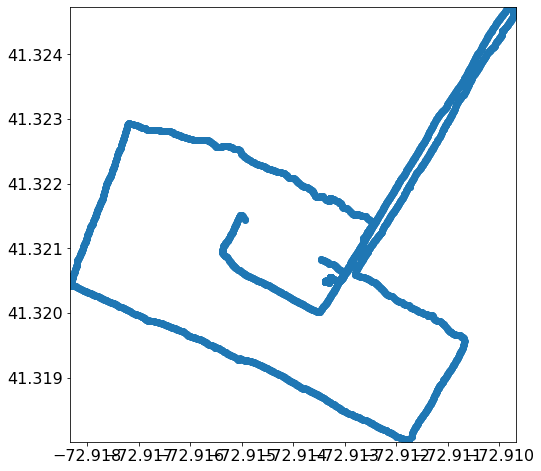

In [74]:
# read in a file using the default pandas read_csv
df = pd.read_csv("./12052154",sep=",",header=0)

# turn the timestamps into real datetime objects
df = df.assign(UTC = pd.to_datetime(df.UTC))

print(df.columns)
    
# make a quick scatter plot
fig = plt.figure()
plt.scatter(df.Lon, df.Lat)
plt.xlim(min(df.Lon), max(df.Lon))
plt.ylim(min(df.Lat), max(df.Lat))

## Column descriptions
* **iTOW**: GPS time of week in milliseconds
* **UTC**: UTC timestamp
* **tAcc**: Time accuracy estimate in nanoseconds
* **Lon**: Longitude in decimal degrees
* **Lat**: Latitude in decimal degrees
* **Height**: Height above the WGS84 ellipsoid in meters
* **HMSL**: Height above mean sea level in meters
* **hAcc**: Horizontal accuracy estimate in millimeters
* **vAcc**: Vertical accuracy estimate in millimeters
* **pDOP**: Position dilution of precision * 100 (unitless measurement of the quality of the current arrangement of satellites overhead)
* **numSV**: Number of satellites currently connected
* **velN, velE, velD**: Velocity in mm/s in NED coordinates
* **gspeed**: 2D ground speed in mm/s
* **headmot**: Heading of motion (note that this is from GPS only, not an IMU, and is not very accurate)
* **sAcc**: Speed accuracy estimate in mm/s
* **headAcc**: Heading accuracy estimate in degrees
* **fixType**: 0 for no fix, 1 for dead-reckoning, 2 for 2D fix, 3 for 3D fix, 4 for GNSS+dead reckoning, 5 for time-only. The ideal value is 3.
* **fixOK**: 1 if the fix is "OK", 0 if not. 
* **UTCvalid**: 1 if the time and date are confirmed to be correct, 0 if not
* **HPvalid**: 1 if the high precision fix if "OK", 0 if not
* **carrierSoln**: 2 if carrier phase ambiguities are fixed, 1 if they're floating, 0 if not corrected. 2 is ideal.
* **diffCorrected**: 1 if differential corrections have been applied, 0 if not

## Plots

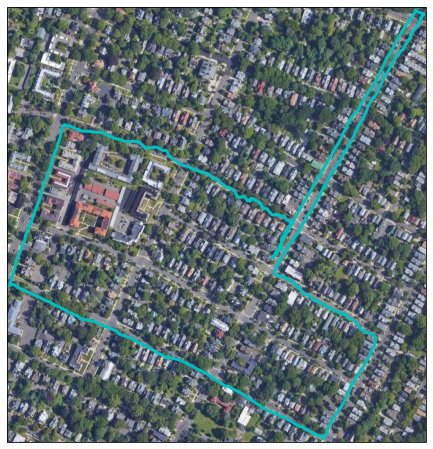

In [84]:
# Plot the data against a variety of basemaps

# choose a plot background
#PLOT_BG = cimgt.Stamen('toner') # black&white lines with street names
#PLOT_BG = cimgt.Stamen('toner-background') # same as toner but no names
#PLOT_BG = cimgt.Stamen('toner-lite') # same as toner but lighter/lower contrast
#PLOT_BG = cimgt.OSM() # open street map
#PLOT_BG = cimgt.GoogleTiles(style='street') # google maps
PLOT_BG = cimgt.GoogleTiles(style='satellite') # google earth
BORDER = 0.00005

fig = plt.figure()

# add a subplot in the coordinate system of the tiles
ax = fig.add_subplot(1, 1, 1, projection=PLOT_BG.crs) 

# set the extents of the plot to be a box around the data
ax.set_extent([min(df.Lon)-BORDER, max(df.Lon)+BORDER, min(df.Lat)-BORDER, max(df.Lat)+BORDER], crs=ccrs.Geodetic())

# use cartopy to add a satellite map to the background
ax.add_image(PLOT_BG, 17) # the number here sets the zoom level (0 is far, 20 is very zoomed in)

# plot the data, transformed into the coordinate system of our plot
plt.plot(df.Lon, df.Lat, 'c', linewidth=3, transform=ccrs.Geodetic(), label="GPS")

# label and save
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.savefig("groundtrack.png")
plt.show()



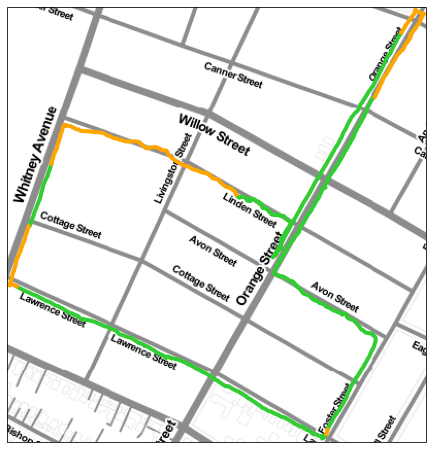

In [85]:
# Visualize the flag columns by conditionally coloring the plot

PLOT_BG = cimgt.Stamen('toner-lite')

BORDER = 0.00005

fig = plt.figure()

# add a subplot in the coordinate system of the tiles
ax = fig.add_subplot(1, 1, 1, projection=PLOT_BG.crs) 

# set the extents of the plot to be a box around the data
ax.set_extent([min(df.Lon)-BORDER, max(df.Lon)+BORDER, min(df.Lat)-BORDER, max(df.Lat)+BORDER], crs=ccrs.Geodetic())

# use cartopy to add a satellite map to the background
#ax.add_image(PLOT_BG, 20, interpolation='spline36')
ax.add_image(PLOT_BG, 16)

# plot the data, transformed into the coordinate system of our plot
df_diff = df.where(df.diffCorrected == 2)
df_nodiff = df.where(df.diffCorrected == 0)
plt.plot(df_diff.Lon, df_diff.Lat, 'c', linewidth=4, transform=ccrs.Geodetic(), label="GPS", color='limegreen')
plt.plot(df_nodiff.Lon, df_nodiff.Lat, 'c', linewidth=4, transform=ccrs.Geodetic(), label="GPS", color='orange')

# label and save
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.savefig("RTK_status.png")
plt.show()


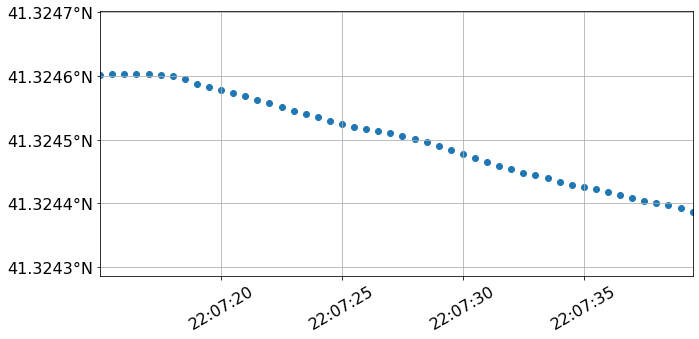

In [89]:
# Plot a variable over time
# This time I picked Latitude, but the process is the same for any of them

fig = plt.figure(figsize=(10,5))
ax = plt.gca()

# Format the timestamp on the x axis as HH:MM:SS
ax.xaxis.set_major_formatter(dates.DateFormatter("%H:%M:%S"))
ax.xaxis_date()

# Uncomment this line to format a latitude axis
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER); ax.yaxis.set_minor_formatter(LATITUDE_FORMATTER)

# Uncomment this line to format a longitude axis 
#ax.yaxis.set_major_formatter(LONGITUDE_FORMATTER); ax.yaxis.set_minor_formatter(LONGITUDE_FORMATTER)

trim_start = 750
trim_stop = 800
plt.scatter(df[trim_start:trim_stop].UTC, df[trim_start:trim_stop].Lat)
plt.grid()
plt.xlim(min(df[trim_start:trim_stop].UTC),max(df[trim_start:trim_stop].UTC))
plt.ylim(min(df[trim_start:trim_stop].Lat)-0.0001,max(df[trim_start:trim_stop].Lat)+0.0001)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()
